# Circular waveguide filter - Discussion

In [1]:
"""
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/circular_waveguide_filter')

# Needed for plotting
import pickle
#root = os.path.abspath(os.path.join('__file__' ,'../../..'))

%load_ext autoreload
%autoreload 2
"""

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('inferno')
np.random.seed(1)

import fenics as fen
from circular_waveguide_filter import CircularWaveguideFilter

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Dual-Mode Circular Waveguide Filter (DMCWF)

### Dimensions and properties

In [3]:
# Dimensions in meters
Lc = 0.04387  # Length of the cavities
Ls = 0.00150  # Length of the slots
Lr = 0.02000  # Length of rectangular input/output WR75-waveguide
Hr = 0.009525 # Height of rectangular input/output WR75-waveguide
Wr = 0.01905  # Width of rectangular input/output WR75-waveguide

Dx = Ls/2 + Lc + Ls + Lr  # |x|-coordinate of input/output boundary
Dy = Wr/2  # |y|-limit of input/output boundary
Dz = Hr/2  # |z|-limit of input/output boundary

In [4]:
class B_N(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(abs(x[0]), Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

class g_N_L(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = 1.0 if fen.near(x[0], -Dx) and x[1] > -Dy and x[1] < Dy and x[2] > -Dz and x[2] < Dz else 0.0
    def value_shape(self):
        return (3,)

class g_N_R(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = - 1.0 if fen.near(x[0], Dx) and x[1] > -Dy and x[1] < Dy and x[2] > -Dz and x[2] < Dz else 0.0
    def value_shape(self):
        return (3,)

mesh = os.getcwd() + '/model/DMCWF.xml'
CWF = CircularWaveguideFilter(mesh, B_N, g_N=[g_N_L(), g_N_R()])
VS = VectorSpaceL2(CWF)
CWF.setup()

### Solution of problem

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


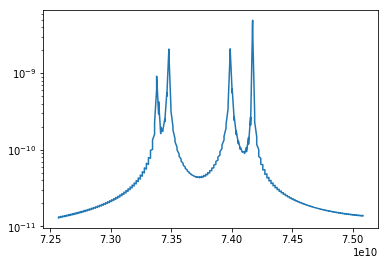

In [5]:
a = 2*np.pi*1.155e+10
b = 2*np.pi*1.195e+10
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
omegas = np.linspace(a, b, 150)
#CWF.solve(omegas, solver='fenics') <--- Uncomment to solve (takes ~ 90 min)
#CWF.save_solution('snapshots/linspace_1.155e+10_1.195e+10_150.obj')
#CWF.load_solution('snapshots/linspace_1.155e+10_1.195e+10_150.obj')
#_ = helpers.plot_solution_norms(ax, CWF, VS)

### Analyzing scattering coefficients

In [6]:
def get_interpolatory_solutions(omega, CWF_L, CWF_R, VS):
    omega_test = np.linspace(np.min(omega), np.max(omega), 1000)
    MRI = MinimalRationalInterpolation(VS)
    MRI_L_hist = MRI.compute_surrogate(CWF_L, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_L = MRI.evaluate_surrogate(CWF_L.get_solution(), omega).T
    MRI_R_hist = MRI.compute_surrogate(CWF_R, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_R = MRI.evaluate_surrogate(CWF_R.get_solution(), omega).T
    U_MRI = np.empty((2*len(omega), U_MRI_R.shape[1]), dtype=complex)
    U_MRI[::2] = U_MRI_L
    U_MRI[1::2] = U_MRI_R
    return U_MRI, MRI_L_hist, MRI_R_hist

In [8]:
freq_c=6.56e+9*2*np.pi
freq_0=1e+10*2*np.pi
def compute_scattering_matrices(F, U, freq, freq_c=freq_c, freq_0=freq_0):
    N = len(freq) // 2
    S = [np.empty((2, 2), dtype=complex)] * N
    for n in range(N):
        S[n][0, 0] = np.inner(F[0], U[2*n])
        S[n][0, 1] = np.inner(F[1], U[2*n])
        S[n][1, 0] = np.inner(F[0], U[2*n+1])
        S[n][1, 1] = np.inner(F[1], U[2*n+1])
        S[n] *= np.sqrt(mu / eps)*1j*freq[n]/(2*np.pi)*np.sqrt((1 - (freq_c/freq_0)**2) / (1 - (freq_c / freq[n])**2))
        S[n] = np.eye(2) - 2 * np.linalg.inv(np.eye(2) + S[n])
    return S

In [9]:
def get_scattering_coefficients(S):
    S11 = np.abs(S)[:, 0, 0]
    S21 = np.abs(S)[:, 1, 0]
    S12 = np.abs(S)[:, 0, 1]
    S22 = np.abs(S)[:, 1, 1]
    return S11, S21, S12, S22

In [10]:
def convert_to_dezibel(x):
    return 20*np.log(x / np.max(x))

In [11]:
freq = CWF.get_frequency()

F = CWF.get_L(tonumpy=True) + CWF.get_N(tonumpy=True)
U_FEM = CWF.get_solution()

CWF_L = CircularWaveguideFilter(mesh, B_N, g_N=g_N_L())
CWF_L.setup()
CWF_R = CircularWaveguideFilter(mesh, B_N, g_N=g_N_R())
CWF_R.setup()
U_MRI, MRI_L_hist, MRI_R_hist = get_interpolatory_solutions(freq[::2], CWF_L, CWF_R, VS)

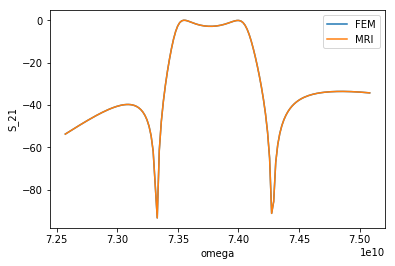

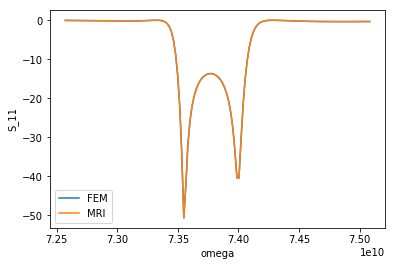

In [12]:
S_FEM = compute_scattering_matrices(F, U_FEM, freq)
S_MRI = compute_scattering_matrices(F, U_MRI, freq)

S11_FEM, S21_FEM, S12_FEM, S22_FEM = get_scattering_coefficients(S_FEM)
S11_MRI, S21_MRI, S12_MRI, S22_MRI = get_scattering_coefficients(S_MRI)

plt.plot(freq[::2], convert_to_dezibel(S21_FEM), label='FEM')
plt.plot(freq[::2], convert_to_dezibel(S21_MRI), label='MRI')
plt.ylabel('S_21')
plt.xlabel('omega')
plt.legend()
plt.show()
plt.plot(freq[::2], convert_to_dezibel(S11_FEM), label='FEM')
plt.plot(freq[::2], convert_to_dezibel(S11_MRI), label='MRI')
plt.ylabel('S_11')
plt.xlabel('omega')
plt.legend()
plt.show()

In [13]:
#with open(root + '/report/plots/circular_waveguide_scattering.pkl', 'wb') as f:
#    pickle.dump([freq[::2], S11_FEM, S11_MRI, S21_FEM, S21_MRI], f)

### Analyze convergence behavior with gMRI

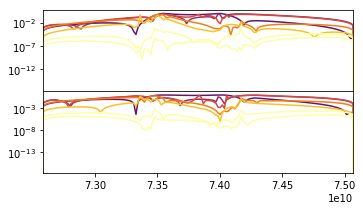

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(5.55, 3), sharex=True)

linspace = CWF.get_frequency()[::2]
u_linspace = CWF.get_solution()

# FOR PLOTTING ONLY
error_S11 = []
error_S21 = []
for i in range(2, 9):
    RI_L = MRI_L_hist[i-2]
    RI_R = MRI_R_hist[i-2]
    
    U_MRI_L = RI_L(linspace).T
    U_MRI_R = RI_R(linspace).T
    U_MRI_ = np.empty((2*len(linspace), U_MRI_R.shape[1]), dtype=complex)
    U_MRI_[::2] = U_MRI_L
    U_MRI_[1::2] = U_MRI_R

    S_FEM = compute_scattering_matrices(F, U_FEM, freq)
    S_MRI = compute_scattering_matrices(F, U_MRI_, freq)

    S11_FEM, S21_FEM, S12_FEM, S22_FEM = get_scattering_coefficients(S_FEM)
    S11_MRI, S21_MRI, S12_MRI, S22_MRI = get_scattering_coefficients(S_MRI)

    ax[0].plot(linspace, np.abs(S11_FEM - S11_MRI), color=cm(i/7))
    ax[1].plot(linspace, np.abs(S21_FEM - S21_MRI), color=cm(i/7))

    error_S11.append(np.abs(S11_FEM - S11_MRI))
    error_S21.append(np.abs(S21_FEM - S21_MRI))

ax[1].set_xlim(np.min(linspace[1:-1]), np.max(linspace[1:-1]))
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.subplots_adjust(wspace=0, hspace=0)

In [20]:
#with open(root + '/report/plots/circular_waveguide_error.pkl', 'wb') as f:
#    pickle.dump([freq[::2], error_S11, error_S21], f)